In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
keras.__version__  # should be 2.2.2

'2.2.2'

In [4]:
import tensorflow as tf
tf.__version__  # should be 1.10.x

'1.11.0-rc1'

In [5]:
import PIL
PIL.__version__  # should be 5.2.0

'5.2.0'

In [6]:
input_path = "../input/alien_vs_predator_thumbnails/data/"

### 2. Create Keras data generators 

In [7]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15,
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    input_path + 'train',
    batch_size=16,
    shuffle=True,
    class_mode='binary',
    target_size=(224,224),
    subset="training"
)

train_steps_per_epoch = train_generator.samples // train_generator.batch_size

validation_data = train_datagen.flow_from_directory(
    input_path + 'train',
    batch_size=16,
    shuffle=True,
    class_mode='binary',
    target_size=(224,224),
    subset="validation"
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    input_path + 'validation',
    batch_size=16,
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

test_steps_per_epoch = test_generator.samples // test_generator.batch_size


Found 590 images belonging to 2 classes.
Found 104 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### 3. Create the network

In [8]:
conv_base = VGG16(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [9]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

predictions = layers.Dense(2, activation='softmax')(x)
model = keras.Sequential()
model = Model(inputs = conv_base.input, outputs = predictions)

In [10]:
model_save = ModelCheckpoint('weights.h5', 
                              save_best_only = True, 
                              save_weights_only = True,
                              monitor = 'val_loss', 
                              mode = 'min', verbose = 1)

In [11]:
optimizer = keras.optimizers.Adam(lr = 0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

### 4. Train the model

In [12]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_steps_per_epoch, 
                              epochs=35,
                              validation_data=validation_data,
                              validation_steps=10,
                              callbacks = [model_save]
                             )

Epoch 1/35
36/36 [==============================] - 14s 391ms/step - loss: 0.6698 - acc: 0.6806 - val_loss: 0.3015 - val_acc: 0.8750

Epoch 00001: val_loss improved from inf to 0.30147, saving model to weights.h5
Epoch 2/35
36/36 [==============================] - 7s 200ms/step - loss: 0.3014 - acc: 0.8676 - val_loss: 0.2227 - val_acc: 0.8947

Epoch 00002: val_loss improved from 0.30147 to 0.22270, saving model to weights.h5
Epoch 3/35
36/36 [==============================] - 8s 234ms/step - loss: 0.3093 - acc: 0.8661 - val_loss: 0.2114 - val_acc: 0.9306

Epoch 00003: val_loss improved from 0.22270 to 0.21141, saving model to weights.h5
Epoch 4/35
36/36 [==============================] - 8s 215ms/step - loss: 0.2612 - acc: 0.8971 - val_loss: 0.1865 - val_acc: 0.9474

Epoch 00004: val_loss improved from 0.21141 to 0.18647, saving model to weights.h5
Epoch 5/35
36/36 [==============================] - 7s 206ms/step - loss: 0.2534 - acc: 0.9025 - val_loss: 0.2118 - val_acc: 0.9306

Epoch 

### 6. Make predictions on sample test images

In [13]:
validation_img_paths = ["validation/alien/11.jpg",
                        "validation/alien/22.jpg",
                        "validation/predator/33.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [14]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [15]:
pred_probs = model.predict(validation_batch)
pred_probs

array([[8.0097967e-01, 1.9902031e-01],
       [9.9960166e-01, 3.9830379e-04],
       [1.3765043e-03, 9.9862349e-01]], dtype=float32)

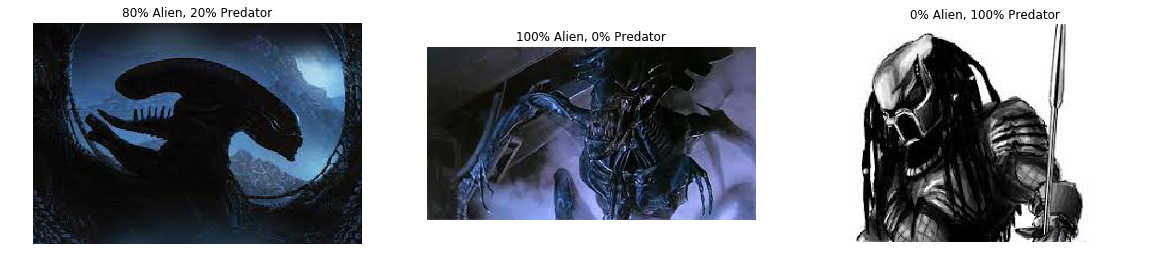

In [16]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

In [17]:
prediction = model.predict_generator(test_generator, steps=(test_steps_per_epoch+1))
prediction = prediction.argmax(axis=-1)

count = 0
for i in range(len(prediction)):
    if (test_generator.classes[i] == prediction[i]):
        count+=1
        
print("Accuracy = ", count/len(prediction) * 100.0)

Accuracy =  94.5


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


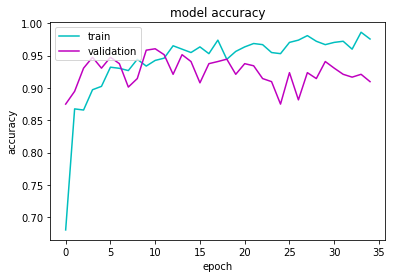

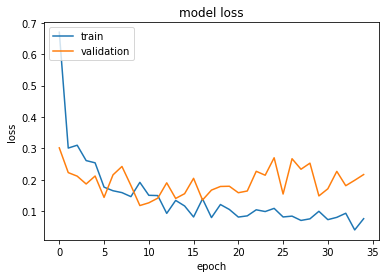

In [18]:
print(history.history.keys())
plt.plot(history.history['acc'],color='c')
plt.plot(history.history['val_acc'],color='m')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Confusion Matrix
[[92  8]
 [ 3 97]]
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.96842   0.92000   0.94359       100
           1    0.92381   0.97000   0.94634       100

   micro avg    0.94500   0.94500   0.94500       200
   macro avg    0.94612   0.94500   0.94497       200
weighted avg    0.94612   0.94500   0.94497       200



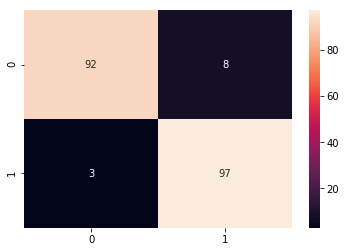

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, prediction)
print(cm)
print(sns.heatmap(confusion_matrix(test_generator.classes, prediction),annot=True,fmt="d"))
print(classification_report(test_generator.classes, prediction, digits=5))